1. Pobierz bazę danych dotyczącą śmiertelnych interwencji policji w USA, a następnie wczytaj ją do obiektu DataFrame.

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

table = pd.read_csv('fatal-police-shootings-data.csv')
table.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


2. Przekształć tabelę w taki sposób, aby wskazywała zestawienie jednocześnie liczby ofiar interwencji według rasy (‘race’) oraz tego, czy wykazywały one oznaki choroby psychicznej (‘signs_of_mental_illness’).

In [15]:
table_1 = table.pivot_table(values='id', index='race', aggfunc='count').reset_index()
table_1.columns = ['race', 'total_count_victim']

table_2 = table.pivot_table(values='id', index='race', columns='signs_of_mental_illness', aggfunc='count')
table_2.columns = ['no_mental_illness', 'mental_illness']

table_race_mental_illness = pd.merge(table_1, table_2, how='inner', on='race')
print(table_race_mental_illness.to_string(index=False))


race  total_count_victim  no_mental_illness  mental_illness
   A                  93                 69              24
   B                1298               1114             184
   H                 902                745             157
   N                  78                 64              14
   O                  48                 37              11
   W                2476               1763             713


3. Za pomocą Map, Applymap lub Apply dodaj do tego zestawienia kolumnę wskazującą jaki odsetek ofiar interwencji wykazywało oznaki choroby psychicznej dla każdej z ras. Odpowiedz, która z nich charakteryzuje się największym odsetkiem znamion choroby psychicznej podczas interwencji.

In [16]:
def mental_illness_pct(row):
    return round((row['mental_illness']*100)/row['total_count_victim'],2)

table_race_mental_illness['percent_mental_illness'] = table_race_mental_illness.apply(lambda row: mental_illness_pct(row), axis=1)
index_max_percent_mental_illness = table_race_mental_illness['percent_mental_illness'].idxmax()
table_race_mental_illness['race'][index_max_percent_mental_illness]


print(table_race_mental_illness.to_string(index=False))
print(f"Grupą która charakteryzuje się największym odsetkiem znamion choroby psychicznej podczas interwencji jest: '{table_race_mental_illness['race'][index_max_percent_mental_illness]}' - {table_race_mental_illness['percent_mental_illness'][index_max_percent_mental_illness]} %.")

race  total_count_victim  no_mental_illness  mental_illness  percent_mental_illness
   A                  93                 69              24                   25.81
   B                1298               1114             184                   14.18
   H                 902                745             157                   17.41
   N                  78                 64              14                   17.95
   O                  48                 37              11                   22.92
   W                2476               1763             713                   28.80
Grupą która charakteryzuje się największym odsetkiem znamion choroby psychicznej podczas interwencji jest: 'W' - 28.8 %.


4. Dodaj kolumnę oznaczającą dzień tygodnia, w którym doszło do interwencji. Zlicz interwencje według odpowiedniego dnia tygodnia. Następnie stwórz wykres kolumnowy, tak aby dni tygodnia były uszeregowane od poniedziałku do niedzieli.

<Figure size 1000x600 with 0 Axes>

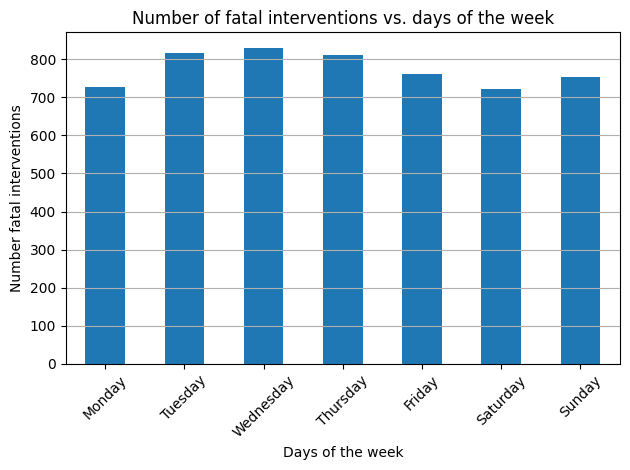

In [17]:
table['date'] = pd.to_datetime(table['date'])
table['name_day'] = table['date'].apply(lambda x: x.day_name())

table_nameday_count = table.pivot_table(index='name_day', values='id',aggfunc='count')

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
table_nameday_count = table_nameday_count.reindex(days)
table_nameday_count

plt.figure(figsize=(10, 6))
table_nameday_count.plot(kind='bar', legend=False)
plt.title('Number of fatal interventions vs. days of the week')
plt.ylabel('Number fatal interventions')
plt.xlabel('Days of the week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')

plt.show()


5. Wczytaj do projektu dane dotyczące populacji w poszczególnych stanach USA oraz dane dotyczące skrótów poszczególnych stanów. Połącz te bazy danych w taki sposób, aby móc policzyć do ilu incydentów w bazie dotyczącej śmiertelnych interwencji doszło w przeliczeniu na 1000 mieszkańców każdego ze stanów.

In [18]:
def funkcja(row):
    population = table_usa_population.loc[row.name]['Census population, April 1, 2020 [1][2]']
    return round(row['id'] / (population / 1000), 2)

table_usa_population = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population', header=0)
table_usa_population = table_usa_population[0]
   
table_state_code = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations', header=0)
table_state_code = table_state_code[1]

table_state_code.fillna({'USPS': table_state_code['Other abbreviations']}, inplace=True)
table_state_code['USPS'] = table_state_code['USPS'].str.slice(0, 2)
table_state_code = table_state_code.iloc[2:]
table_state_code.set_index(['USPS'],inplace=True)
table_usa_population.set_index(['State'],inplace=True)

table = table.join(table_state_code,how='inner', on='state')
table = table.join(table_usa_population,how='inner', on='Name')

table_count_by_state = table.pivot_table(index='Name', values='id', aggfunc = 'count')
table_count_by_state['Number of interventions per thousand inhabitants'] = table_count_by_state.apply(funkcja, axis=1)
table_count_by_state.rename(columns={'id':'Count fatal intervention'},inplace=True)
table_count_by_state.index.name = 'State name'
table_count_by_state

,Count fatal intervention,Number of interventions per thousand inhabitants
State name,,
Alabama,104,0.02
Alaska,39,0.05
Arizona,254,0.04
Arkansas,83,0.03
California,799,0.02
Colorado,195,0.03
Connecticut,21,0.01
Delaware,13,0.01
District of Columbia,13,0.02
